**Отчет 1: Влияние факторов на абсолютеную цену лотов**

Площадь вносит самый большой, несравнимый с иными признаками вклад в абсолютную цену лота.

* Рассмотрим зависимость от среднего прироста информационного критерия по признаку
    * Самый значимый средни вклад по деревьям в цену оказывает площадь
    * Без учета площади, самым важным критерием разбиения оказывается количество комнат
    * Вклад района и количества санузлов с точки зрения нашей модели схож. Вероятная причина в высокой корреляции между количеством санузлов и площадью (выше, чем с количетсвом комнат) 
    * Далее следуют округ, возраст и тип дома
    
* Также, можно рассмотреть зависимость от количества использования признака в узлах при посроении наших деревьей (`the number of times a feature is used to split the data across all trees)
    * Наиболе часто начинает появляться район, за ним следует метро и возраст дома
    * Частота использования признака Доля жилой площади схожа с возрастом дома и Этажностью в доме. 
    * Интересно, что возраст (медианный=18) обратно пропорционален этажности (медианная=16)
    * Частота использования признака доли куханной площади примерно равна частоте использования доли жилой площади
    
Рекомендуется изучить связи между ценой за квадратный метр, чтобы кажущиеся очевидным влияние площади.

#### Влияние ветки метро
* Для измерения следует обработать данные по станциям, которые встречаются в более чем одной ветке. Например, станция Третьяковская по данным с портала открытых данных города Москвы ([ссылка](https://data.mos.ru/classifier/7704786030-stantsii-moskovskogo-metropolitena) расположена одновременно на трех ветках, одна из которых еще строится. Доступная выгрузка из источника данных не дает такой подробной информации. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder
import statsmodels
PATH_TO_DATA = './data/'

from collections import defaultdict
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import lightgbm as lgbm
import eli5
import scipy.stats

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
df = pd.read_csv(PATH_TO_DATA + 'features_dataset.csv', index_col=[0])
target = pd.read_csv(PATH_TO_DATA + 'target_column.csv', index_col=[0])
print(df.shape)
print(f'{df.memory_usage().sum() / 1024 / 1024 :.2f} Mb')
assert df.shape[0] == target.shape[0]

(14329, 25)
1.98 Mb


In [3]:
df.nunique()

Округ                                 12
Район                                153
Площадь                             1736
Площадь лог                         1736
Кол-во комнат                          7
Этаж                                  73
Этажей в доме                         73
Первый этаж                            2
Последний этаж                         2
Метро                                272
Расстояние до метро (ед)              57
Расстояние указано пешком              2
Расстояние указано на транспорте       2
Тип дома                               7
Указан раздельный санузел              2
Несколько санузлов                     2
Балкон указан                          2
Окна                                   3
Окна во двор                           2
Ремонт                                 4
Наличие ремонта                        2
Возраст дома                         126
Доля жилой площади                  6121
Доля куханной площади               5252
Площадь кухни   

### Предобрабатываем

> Закодируем категориальные признки (Округ, Район, Кол-во комнат, метро)

In [4]:
df.head(1)

,Округ,Район,Площадь,Площадь лог,Кол-во комнат,Этаж,Этажей в доме,Первый этаж,Последний этаж,Метро,...,Несколько санузлов,Балкон указан,Окна,Окна во двор,Ремонт,Наличие ремонта,Возраст дома,Доля жилой площади,Доля куханной площади,Площадь кухни
0,ВАО,р-н Гольяново,33.0,3.496508,1,9.0,9.0,False,True,Первомайская,...,False,False,Во двор,True,Без ремонта,False,51.0,0.484848,0.212121,7.0


In [5]:
logging.info(f'Предобрабатываем: {df.columns[df.dtypes == "object"].values.tolist()}.')
label_encoder_dict = defaultdict(LabelEncoder)

df['Округ'] = df['Округ'].astype(str)
df['Район'] = df['Район'].astype(str)
df['Кол-во комнат'] = df['Кол-во комнат'].astype(str)
df['Метро'] = df['Метро'].astype(str)
df['Тип дома'] = df['Тип дома'].astype(str)
df['Окна'] = df['Окна'].astype(str)
df['Ремонт'] = df['Ремонт'].astype(str)

# df['Доля жилой площади'] = df['Доля жилой площади'].fillna(df.groupby('Кол-во комнат')['Доля жилой площади'].transform('median'))
# pd.get_dummies(df, columns=['Кол-во комнат', 'Метро', 'Тип дома', 'Окна', 'Ремонт'])
# df['Площадь'] = np.log(df['Площадь'])

cat_columns = df.columns[df.dtypes == 'object']
df[cat_columns] = df[cat_columns].apply(lambda x: label_encoder_dict[x.name].fit_transform(x)).astype('category')
# label_encoder_dict['Округ'].inverse_transform([8])
# df[cat_columns].apply(lambda x: label_encoder_dict[x.name].inverse_transform(x))

logging.info(f'Предобработка: завершение')

INFO:root:Предобрабатываем: ['Округ', 'Район', 'Кол-во комнат', 'Метро', 'Тип дома', 'Окна', 'Ремонт'].
INFO:root:Предобработка: завершение


### Моделируем

> Зависимость цены за метр^2 от признаков всех категорий жилья

In [6]:
def metrics_report(y_pred : np.array, y_true : np.array):
    '''
    Вывод метрик качества и графика рассеивания
    :input:
        predicted and background truth targets
    :return: 
        R2 and Mean Absolute Errors metrics values
    '''
    r2 = sklearn.metrics.r2_score(y_pred, y_true)
    mae = sklearn.metrics.mean_absolute_error(y_pred, y_true)
    mse = sklearn.metrics.mean_squared_error(y_pred, y_true)
    
    plt.scatter(y=y_pred, x=y_true, alpha=0.25);
    plt.ylabel('predicted log(Цена за метр^2)')
    plt.xlabel('log(Цена за метр^2)')
    plt.title('Диаграмма рассеивания (log(ˆp), log(p))')
    
    logging.info(f'R2 = {r2:.2f}; MAE = {mae:.2f}; MSE = {mse:.2f}')
    return r2, mae, mse

In [7]:
cols_not_to_use = ['Площадь', 'Площадь лог', 'Площадь кухни']
target_col = 'Цена'

logging.info(f'Моделируем: {target_col}.')
logging.info(f'Не используем: {cols_not_to_use}.')
logging.info(f'Используем: {list(df.columns[~df.columns.isin(cols_not_to_use)])}.')

INFO:root:Моделируем: Цена.
INFO:root:Не используем: ['Площадь', 'Площадь лог', 'Площадь кухни'].
INFO:root:Используем: ['Округ', 'Район', 'Кол-во комнат', 'Этаж', 'Этажей в доме', 'Первый этаж', 'Последний этаж', 'Метро', 'Расстояние до метро (ед)', 'Расстояние указано пешком', 'Расстояние указано на транспорте', 'Тип дома', 'Указан раздельный санузел', 'Несколько санузлов', 'Балкон указан', 'Окна', 'Окна во двор', 'Ремонт', 'Наличие ремонта', 'Возраст дома', 'Доля жилой площади', 'Доля куханной площади'].


In [8]:
regressor = lgbm.LGBMRegressor(max_depth=7, n_estimators=500, 
                               num_leaves=12, reg_alpha=2, #reg_beta=2,
                               importance_type='split', 
                               random_state=42)

INFO:root:R2 = 0.97; MAE = 0.11; MSE = 0.02


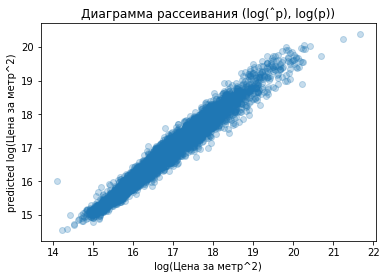

In [9]:
regressor.fit(df.iloc[:, ~df.columns.isin(cols_not_to_use)], 
              np.log(target[target_col].values));
metrics_report(regressor.predict(df.iloc[:, ~df.columns.isin(cols_not_to_use)]),
               np.log(target[target_col].values));

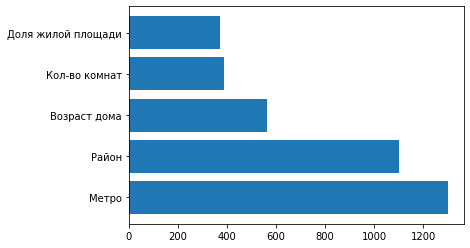

In [10]:
y = df.iloc[:, ~df.columns.isin(cols_not_to_use)].columns[regressor.feature_importances_.argsort()[::-1][:5]]
x = regressor.feature_importances_[regressor.feature_importances_.argsort()[::-1][:5]]
plt.barh(width=x, y=y);

In [11]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='gain')

Weight,Feature
0.5314,Район
0.2694,Кол-во комнат
0.0820,Метро
0.0488,Возраст дома
0.0255,Несколько санузлов
0.0115,Ремонт
0.0078,Этажей в доме
0.0070,Тип дома
0.0050,Доля куханной площади
0.0047,Доля жилой площади


In [12]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.2365,Метро
0.2000,Район
0.1027,Возраст дома
0.0702,Кол-во комнат
0.0675,Доля жилой площади
0.0649,Доля куханной площади
0.0618,Этажей в доме
0.0449,Этаж
0.0380,Расстояние до метро (ед)
0.0264,Ремонт


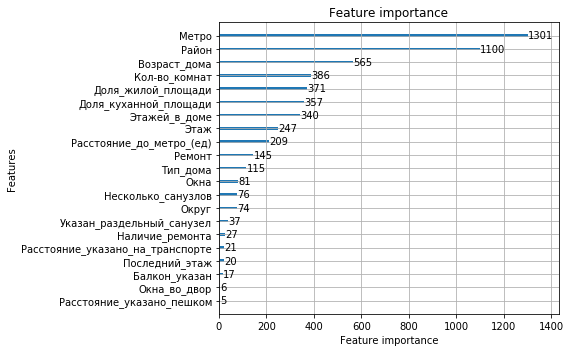

In [13]:
lgbm.plot_importance(regressor, figsize=(8, 5))
plt.tight_layout();

> Посмотрим на связь признаков
* Корреляции Пирсона для количественным и Спирмана для качественных

* *Логорифм от площади, чтобы сгладить выбросы цены на графике и не удалять их*

Text(0.5, 0, 'Цена за метр^2 (лог)')

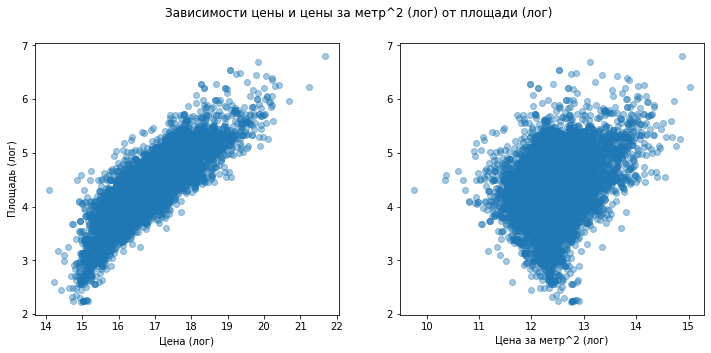

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Зависимости цены и цены за метр^2 (лог) от площади (лог)')
ax[0].scatter(x=np.log(target['Цена'].values), y=np.log(df['Площадь'].values), alpha=0.4)
ax[1].scatter(x=np.log(target['Цена за метр^2'].values), y=np.log(df['Площадь'].values), alpha=0.4)

ax[0].set_ylabel('Площадь (лог)')
ax[0].set_xlabel('Цена (лог)')
ax[1].set_xlabel('Цена за метр^2 (лог)')

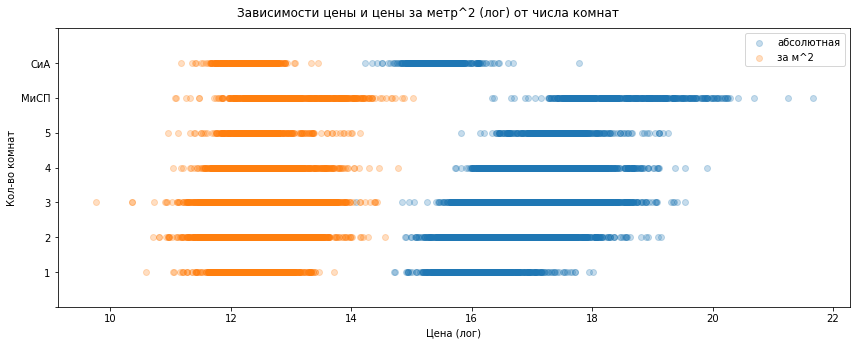

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Зависимости цены и цены за метр^2 (лог) от числа комнат')
ax.scatter(x=np.log(target['Цена'].values), y=df['Кол-во комнат'].values, alpha=0.25, label='абсолютная')
ax.scatter(x=np.log(target['Цена за метр^2'].values), y=df['Кол-во комнат'].values, alpha=0.25, label='за м^2')
#plt.scatter(x=np.log(target['Цена за метр^2'].values), y=df['Кол-во комнат'].values, alpha=0.4)
ticks = [label_encoder_dict['Кол-во комнат'].inverse_transform([int(tick)])[0] for tick in plt.yticks()[0].tolist()[1:-1]]
plt.yticks(plt.yticks()[0], [''] + ticks + ['']);

ax.set_ylabel('Кол-во комнат')
ax.set_xlabel('Цена (лог)');
plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

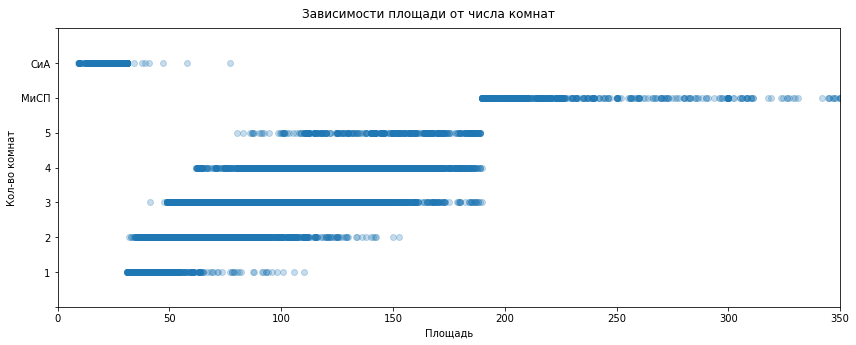

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Зависимости площади от числа комнат')
ax.scatter(x=df['Площадь'].values, y=df['Кол-во комнат'].values, alpha=0.25)
ticks = [label_encoder_dict['Кол-во комнат'].inverse_transform([int(tick)])[0] for tick in plt.yticks()[0].tolist()[1:-1]]
plt.yticks(plt.yticks()[0], [''] + ticks + ['']);
ax.set_ylabel('Кол-во комнат')
ax.set_xlabel('Площадь');
ax.set_xlim(0, 350)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [17]:
scipy.stats.spearmanr(np.log(target['Цена'].values), 
                    df['Возраст дома'].fillna(df.groupby(['Кол-во комнат'])['Возраст дома'].transform('median')))

SpearmanrResult(correlation=-0.24250503227812728, pvalue=7.591839705597098e-191)

In [18]:
scipy.stats.spearmanr(np.log(target['Цена за метр^2'].values), 
                    df['Возраст дома'].fillna(df.groupby(['Кол-во комнат'])['Возраст дома'].transform('median')))

SpearmanrResult(correlation=-0.03343832304594931, pvalue=6.2421534354354e-05)

Интересные характеристики лотов
* Наличие более одного санузла, сильнее связано с площадью, чем с количеством комнат. А площадь уже связано с количеством комнат.
* Число этажей обратно пропорционально возрасту дома. Наверное, это ожидаемо, при учете медианного возраста дома в $20$ лет ($18$ без обработки пропусков), а медианного количества этажей в доме равного $16$

In [19]:
scipy.stats.spearmanr(df['Кол-во комнат'].values, df['Несколько санузлов'].values)

SpearmanrResult(correlation=0.2723271747586393, pvalue=4.587435724451326e-242)

In [20]:
scipy.stats.spearmanr(df['Площадь'].values, df['Несколько санузлов'].values)

SpearmanrResult(correlation=0.5148898159125749, pvalue=0.0)

In [21]:
scipy.stats.spearmanr(df['Площадь'].values, df['Кол-во комнат'].values)

SpearmanrResult(correlation=0.6047449898902657, pvalue=0.0)

In [22]:
scipy.stats.spearmanr(df['Этажей в доме'].values,
                      df['Возраст дома'].fillna(df.groupby(['Кол-во комнат'])['Возраст дома'].transform('median')))

SpearmanrResult(correlation=-0.5032993608981183, pvalue=0.0)

* Район сильнее связан как с абсолютной ценой, так и с ценой за метр квадратный, чем округ

In [23]:
df['Возраст дома'].fillna(df.groupby('Кол-во комнат')['Возраст дома'].transform('median')).values

array([51., 57., 52., ..., 16., 14., 14.])

In [24]:
scipy.stats.spearmanr(df['Район'].values, target.astype(int)['Цена'].values)

SpearmanrResult(correlation=0.29927339405128434, pvalue=2.684018004584051e-294)

In [44]:
scipy.stats.spearmanr(df['Округ'].values, target.astype(int)['Цена'].values)

SpearmanrResult(correlation=0.013093238263086763, pvalue=0.11705840984265456)

In [45]:
scipy.stats.spearmanr(df['Округ'].values, df['Район'].values)

SpearmanrResult(correlation=0.1816024438216906, pvalue=1.7081157092008862e-106)

In [25]:
scipy.stats.spearmanr(df['Метро'].values, target.astype(int)['Цена'].values)

SpearmanrResult(correlation=0.09587336239647344, pvalue=1.2903323021515915e-30)

* По не ясной причине, доля куханной площади обратно пропорционально площади. Возможно, дело в количестве пропусков и том, что мы не имеем полной картины 

In [26]:
np.corrcoef(df['Площадь'].values, 
            df['Доля жилой площади'].fillna(df.groupby('Кол-во комнат')['Доля жилой площади'].transform('median')))

array([[1.       , 0.1679089],
       [0.1679089, 1.       ]])

In [27]:
np.corrcoef(df['Площадь'].values, 
            df['Доля куханной площади'].fillna(df.groupby('Кол-во комнат')['Доля куханной площади'].transform('median')))

array([[ 1.        , -0.43344788],
       [-0.43344788,  1.        ]])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


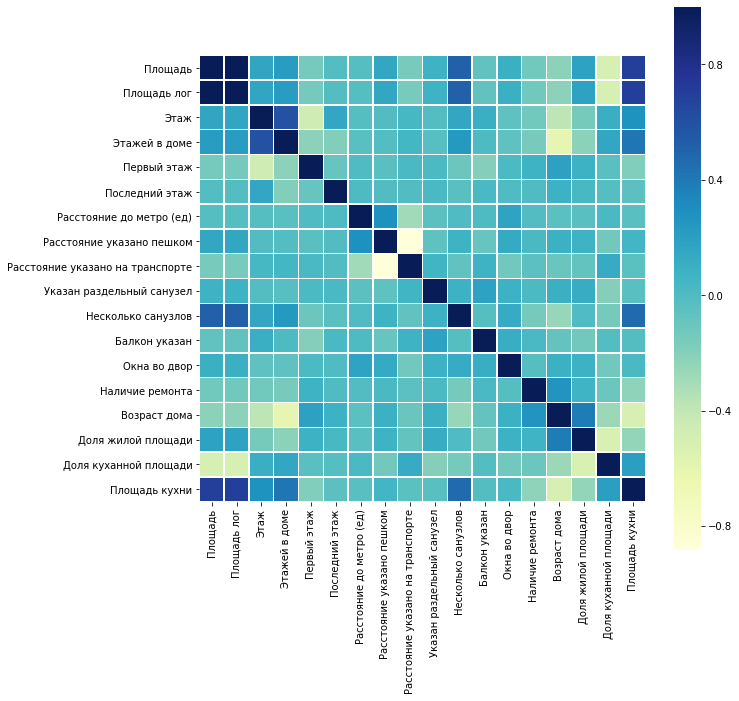

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(method='spearman'), linewidth=0.5, square=True,  cmap="YlGnBu")

> Также, на всякий случай рассмотрим качество модели на отложенной выборке

In [29]:
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(df.iloc[:, ~df.columns.isin(cols_not_to_use)], 
                                                                              np.log(target[target_col]), 
                                                                              test_size = 0.2, 
                                                                              shuffle = True, 
                                                                              stratify = df['Кол-во комнат'], 
                                                                              random_state = 891)
train_data = lgbm.Dataset(train_x, label=train_y)
valid_data = lgbm.Dataset(valid_x, label=valid_y)

In [30]:
params = {'metric' : 'mse',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.9234,
          'num_leaves' : 7,
          'max_depth' : -1,
          'n_estimators' : 8000,
          'min_child_samples': 399, 
          'min_child_weight': 0.1,
          'reg_alpha': 2,
          #'reg_lambda': 5,
          'subsample': 0.855,
          'verbose' : 100,
          'num_threads' : 2}

In [31]:
#Train model on selected parameters and number of iterations
regressor_2 = lgbm.train(params,
                 train_data,
                 2500,
                 valid_sets = valid_data,
                 early_stopping_rounds = 120,
                 verbose_eval = 500
                 )
regressor_2.booster_ = regressor_2

D:\Anaconda\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 120 rounds.
[500]	valid_0's l2: 0.0514025
[1000]	valid_0's l2: 0.049152
[1500]	valid_0's l2: 0.0482956
Early stopping, best iteration is:
[1579]	valid_0's l2: 0.0482581


INFO:root:R2 = 0.93; MAE = 0.15; MSE = 0.05


(0.9281554827250201, 0.1505460682244332, 0.04825812179053619)

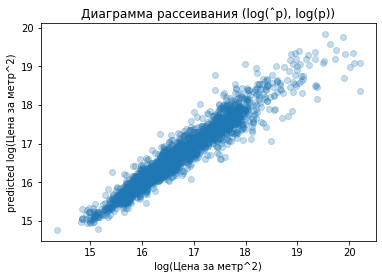

In [32]:
metrics_report(regressor_2.predict(valid_x), valid_y)

In [33]:
eli5.explain_weights_lightgbm(regressor_2, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='gain')

Weight,Feature
0.5208,Район
0.2683,Кол-во комнат
0.0962,Метро
0.0475,Возраст дома
0.0289,Несколько санузлов
0.0113,Ремонт
0.0067,Тип дома
0.0052,Доля куханной площади
0.0050,Этажей в доме
0.0041,Этаж


In [34]:
eli5.explain_weights_lightgbm(regressor_2, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.2922,Метро
0.2425,Район
0.0830,Возраст дома
0.0757,Кол-во комнат
0.0593,Доля жилой площади
0.0519,Доля куханной площади
0.0459,Этажей в доме
0.0292,Этаж
0.0270,Ремонт
0.0249,Расстояние до метро (ед)


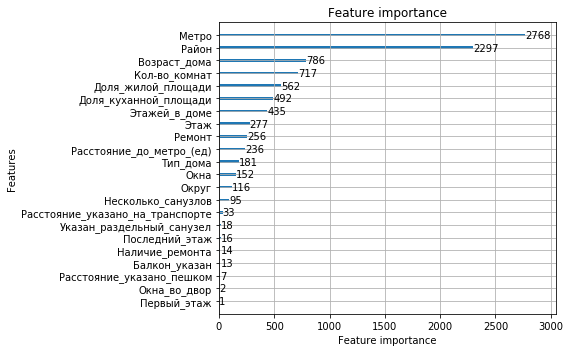

In [35]:
lgbm.plot_importance(regressor_2, importance_type='split', figsize=(8, 5))
plt.tight_layout()

> Посмотрим на еще один способ изучить значимость признаков
* SHAP

In [36]:
import shap

Wall time: 0 ns


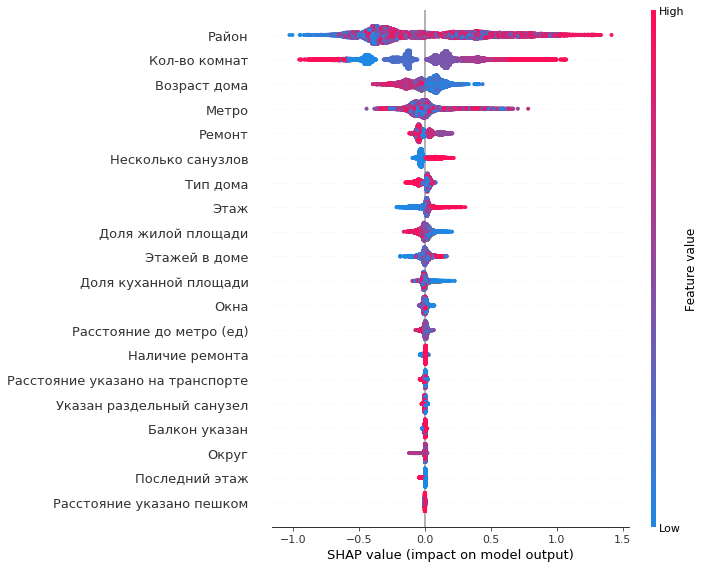

In [37]:
%time
# https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(df.iloc[:, ~df.columns.isin(cols_not_to_use)])
shap.summary_plot(shap_values, df.iloc[:, ~df.columns.isin(cols_not_to_use)])

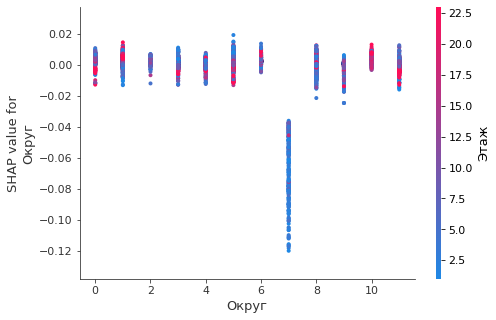

In [38]:
shap.dependence_plot("Округ", shap_values, df.iloc[:, ~df.columns.isin(cols_not_to_use)])

In [39]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0:1], 
                df.iloc[:, ~df.columns.isin(cols_not_to_use)][0:1])

In [40]:
df.iloc[:, :][0:1]

,Округ,Район,Площадь,Площадь лог,Кол-во комнат,Этаж,Этажей в доме,Первый этаж,Последний этаж,Метро,...,Несколько санузлов,Балкон указан,Окна,Окна во двор,Ремонт,Наличие ремонта,Возраст дома,Доля жилой площади,Доля куханной площади,Площадь кухни
0,0,53,33.0,3.496508,0,9.0,9.0,False,True,159,...,False,False,1,True,1,False,51.0,0.484848,0.212121,7.0


In [41]:
label_encoder_dict['Кол-во комнат'].inverse_transform([0])

array(['1'], dtype=object)

In [42]:
label_encoder_dict['Округ'].inverse_transform([0])

array(['ВАО'], dtype=object)

In [43]:
label_encoder_dict['Метро'].inverse_transform([159])

array(['Первомайская'], dtype=object)